In [3]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
XCr_path = os.getcwd()+'/../'
sys.path.append(XCr_path)
from XCrystal import *
from scipy.spatial.transform import Rotation as R

In [4]:
xcr = XCrystal(XCr_path+'/config/C400_9p8keV_LaueAssymRefl15degFig2.yaml')
pp=xcr.configure(0,0)

No deformation model was selected


In [7]:
grid_size = (len(xcr.xx), len(xcr.yy), len(xcr.z))

In [21]:
grid_size

(4000, 4, 12000)

In [132]:
def rotate_plate_on_grid_optimized(grid_size, plate_center, plate_size, thickness, rotation_axis, rotation_angle):
    
    nx, ny, nz = grid_size
    x = np.linspace(-1000, 1000, nx)
    y = np.linspace(-1000, 1000, ny)
    z = np.linspace(-1000, 1000, nz)
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

    # Stack the coordinates
    coords = np.stack((X, Y, Z), axis=-1) #- plate_center

    # Create rotation matrix
    rotation = R.from_rotvec(np.deg2rad(rotation_angle) * np.array(rotation_axis))
    rotation_matrix = rotation.as_matrix()

    # Apply rotation
    rotated_coords = np.tensordot(coords, rotation_matrix, axes=([3], [1]))

    # Conditions for the plate
    length, width = plate_size
    half_thickness = thickness / 2

    cond_x = np.abs(rotated_coords[..., 0]) <= length / 2
    cond_y = np.abs(rotated_coords[..., 1]) <= width / 2
    cond_z = np.abs(rotated_coords[..., 2]) <= half_thickness

    plate_mask = cond_x & cond_y & cond_z

    return plate_mask#, X, Y, Z


def rotate_plate_xcr(xcr, plate_center, plate_size, thickness, rotation_axis, rotation_angle):
    
    x = xcr.xx
    y = xcr.yy
    z = xcr.z
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

    # Stack the coordinates
    coords = np.stack((X, Y, Z), axis=-1) - plate_center

    # Create rotation matrix
    rotation = R.from_rotvec(np.deg2rad(rotation_angle) * np.array(rotation_axis))
    rotation_matrix = rotation.as_matrix()

    # Apply rotation
    rotated_coords = np.tensordot(coords, rotation_matrix, axes=([3], [1]))

    # Conditions for the plate
    length, width = plate_size
    half_thickness = thickness / 2

    cond_x = np.abs(rotated_coords[..., 0]) <= length / 2
    cond_y = np.abs(rotated_coords[..., 1]) <= width / 2
    cond_z = np.abs(rotated_coords[..., 2]) <= half_thickness

    plate_mask = cond_x & cond_y & cond_z

    return plate_mask#, X, Y, Z

In [186]:
grid_size = (500,3,400)
XiArray = np.zeros(grid_size)
mask = rotate_plate_on_grid_optimized(grid_size, (0, 0, 0), (500, 25), 300, (0, 1, 0), -15)

In [187]:
XiArray[mask]=1.0

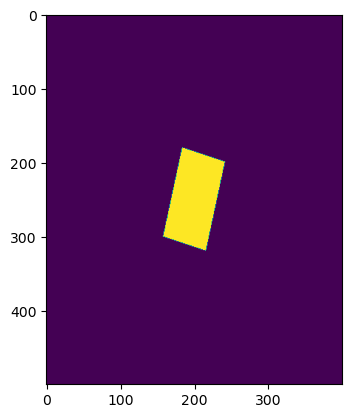

In [188]:
plt.imshow(XiArray[:,1,:], aspect='equal')

In [189]:
XiArray = np.zeros(grid_size)
mask1 = rotate_plate_on_grid_optimized(grid_size, (0, 0, 0), (150, 25), 20, (0, 1, 0), 15.0)
#mask2 = rotate_plate_on_grid_optimized(grid_size, (0, 0, -20), (150, 25), 5, (0, 1, 0), 15.0)

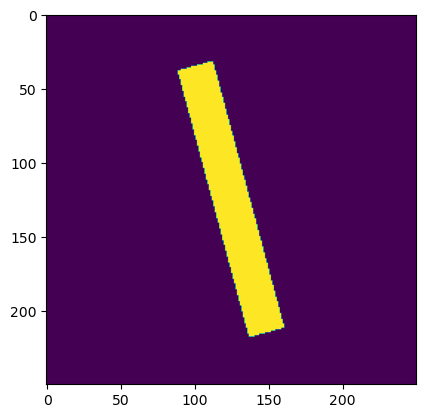

In [13]:
XiArray[mask1]=1.0
#XiArray[mask2]=-1.0

plt.imshow(XiArray[:,50,:])

In [14]:
np.shape(xcr.xx)[0]

4000

In [15]:
XCrArray = np.zeros((np.shape(xcr.xx)[0], np.shape(xcr.yy)[0], np.shape(xcr.z)[0]))
mask1 = rotate_plate_xcr(xcr, (xcr.xs, 0, 0), (xcr.HH, xcr.width*1e-6*xcr.convr), xcr.CrSize*1e-6*xcr.convr, (0, 1, 0), -np.rad2deg(xcr.asymm_angle))

In [16]:
XCrArray[mask1]=1.0

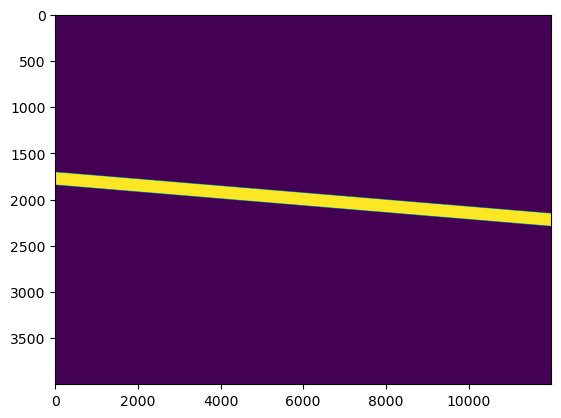

In [22]:
plt.imshow(XCrArray[:,0,:], aspect='auto')

In [18]:
np.shape(mask1)

(4000, 1, 12000)

In [21]:
np.save('Asymm.geom',mask1) 